In [47]:

import cv2
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import skimage.transform
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.auto import tqdm, trange
from sklearn.metrics import confusion_matrix
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import DataLoader, random_split
from typing import Dict, Final, List, Tuple, NamedTuple, Type


In [31]:


FAIL = 2 
PASS = 1 
NO_DIE = 0  

Loss: Type = float
Accuracy: Type = float

class LossAcc(NamedTuple):
    loss: Loss
    accuracy: Accuracy

class TrainValLossAcc(NamedTuple):
    train: List[List[LossAcc]]
    val: List[LossAcc]





In [32]:
df_train: pd.DataFrame = pd.DataFrame.from_records(np.load('wafermap_train.npy', allow_pickle=True))
classes: Final[List[str]] = df_train.failureType.unique()

num_classes: Final[int] = len(classes)

num_epochs: Final[int] = 20

batch_size: Final[int] = 16

test_set_size: Final[float] = 0.30

test_set_sample_count: Final[int] = int(test_set_size * len(df_train))

test_set_actual_size: Final[float] = test_set_sample_count / len(df_train)


NO_DIE: Final[int] = 0
PASS_DIE: Final[int] = 1
FAIL_DIE: Final[int] = 2
NUM_DIE_STATES: Final[int] = 3


print("Number of classes: ", num_classes)
print("Number of epochs: ", num_epochs)
print("Batch size: ", batch_size)
print("Test set size: {:.2f}%".format(test_set_actual_size * 100))
print("Test set sample count: ", test_set_sample_count)

Number of classes:  5
Number of epochs:  20
Batch size:  16
Test set size: 30.00%
Test set sample count:  540


In [33]:
def convert_failure_type(failure_type: str) -> int:
    string2int: Final[Dict[str, int]] = {'Edge-Loc':0, 'Scratch':1, 'Donut':2, 'Center':3, 'Near-full':4}

    return string2int[failure_type]


def resize_wafer_map(wafer_map: np.ndarray, output_shape: tuple = (64, 64)) -> np.ndarray:
    resized = cv2.resize(wafer_map, output_shape, interpolation=cv2.INTER_NEAREST)
    ret = np.eye(NUM_DIE_STATES)[resized]
    ret = ret.transpose(2, 1, 0)
    return ret


In [34]:
class WaferDataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = self.df.loc[idx, 'waferMap']
        img = resize_wafer_map(img) 
        img = img.astype('float32')
        img = torch.from_numpy(img)
        label = self.df.loc[idx, 'failureType']
        label = convert_failure_type(label)
        label = torch.tensor(label)
        return img, label

In [35]:
all_dataset = WaferDataset(df_train)
train_set_sample_count = len(df_train) - test_set_sample_count
train_dataset, val_dataset = random_split(all_dataset, [ train_set_sample_count, test_set_sample_count], generator=torch.Generator().manual_seed(9))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


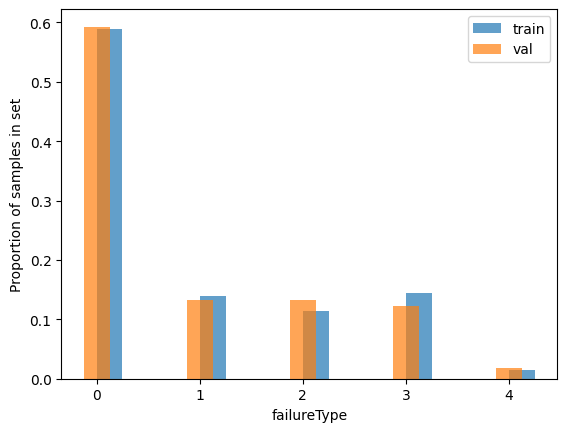

In [36]:
train_labels = pd.DataFrame(
    Counter(l.item() for _, l in train_dataset).items(),
    columns=['failureType', 'count']
)
val_labels = pd.DataFrame(
    Counter(l.item() for _, l in val_dataset).items(),
    columns=['failureType', 'count']
)
train_labels['train'] = True
train_labels['ratio'] = train_labels['count'] / (train_labels['count'].sum())
val_labels['train'] = False
val_labels['ratio'] = val_labels['count'] / (val_labels['count'].sum())
labels = pd.concat([train_labels, val_labels])

plt.bar(labels[labels['train']]['failureType'],
        labels[labels['train']]['ratio'], label='train', alpha=0.7, width=0.25, align='edge')
plt.bar(labels[~labels['train']]['failureType'],
        labels[~labels['train']]['ratio'], label='val', alpha=0.7, width=0.25)
plt.legend()
plt.xlabel('failureType')
plt.ylabel('Proportion of samples in set')
plt.show()

In [37]:
def validate(model: nn.Module, val_data: DataLoader) -> LossAcc:
   
    model.eval()
    with torch.no_grad():
        total_correct = 0.0
        totalLoss = 0.0
        total = 0
        for i, batch in enumerate(val_data):
            data, labels = batch
            outputs = model(data)
            loss = nn.functional.cross_entropy(outputs, labels)
            
            predicted = outputs.argmax(dim=1)
            total += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            
            totalLoss += loss.item()
            
        return LossAcc(totalLoss/len(val_data), total_correct/total)
    
def train_batch(model: nn.Module, optimizer: optim.Optimizer,
                inputs: torch.Tensor, labels: torch.Tensor) -> LossAcc:
    model.train()
    optimizer.zero_grad()
    y_pred = model(inputs)
    loss = nn.functional.cross_entropy(y_pred, labels)
    loss.backward()
    
    optimizer.step()
    with torch.no_grad():
        
        predicted = y_pred.argmax(dim=1)
        total = labels.size(0)
        total_correct = (predicted == labels).sum().item()
        
        return LossAcc(loss.item(), total_correct/total)

def train_epoch(model: nn.Module, optimizer: optim.Optimizer,
                train_data: DataLoader) -> List[LossAcc]:

    LossAccList = []
    
    for batch in train_data:
        
        data, labels = batch
        
        batch_loss_acc = train_batch(model, optimizer, data, labels)
        
        LossAccList.append(batch_loss_acc)
    
    return LossAccList

def train_loop(model: nn.Module, optimizer: optim.Optimizer,
               train_data: DataLoader, val_data: DataLoader,
               num_epochs: int = 10) -> TrainValLossAcc:
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        
        train_loss_acc = train_epoch(model, optimizer,train_data)
        
        val_loss_acc = validate(model, val_data)
        
        train_losses.append(train_loss_acc)
        val_losses.append(val_loss_acc)
    
    return TrainValLossAdcc(train_losses, val_losses)

In [38]:
num_classes = 5

features = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(inplace=True),
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(inplace=True),
    nn.Conv2d(32, 16, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(inplace=True)
)

num_out_features: int = int(np.prod(features(torch.rand(1, 3, 64, 64)).shape[1:]))
print("Feature out shape: ", features(torch.rand(1, 3, 64, 64)).shape, \
    ' = ', np.prod(features(torch.rand(1,3,64,64)).shape))

classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=num_out_features, out_features=512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.3, inplace=False),
    nn.Linear(in_features=512, out_features=5)
)

# Instantiate a neural network model
model = nn.Sequential(
    features,
    classifier
)
model

Feature out shape:  torch.Size([1, 16, 7, 7])  =  784


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=5, bias=True)
  )
)

In [39]:
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)
history: TrainValLossAcc = train_loop(
    model, optimizer, train_dataloader, val_dataloader)


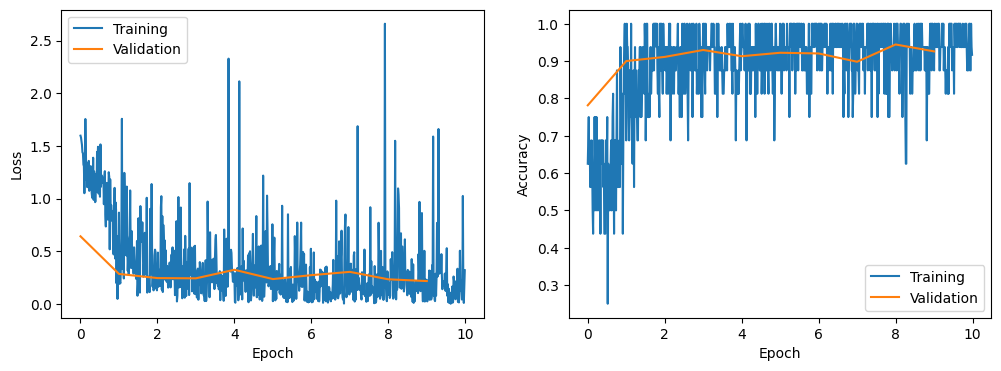

In [40]:
training_history = pd.DataFrame.from_records(
    [loss for batch_losses in history.train for loss in batch_losses],
    columns=LossAcc._fields)
training_history['epoch'] = training_history.index / len(train_dataloader)
validation_history = pd.DataFrame.from_records(
    history.val, columns=LossAcc._fields)
validation_history['epoch'] = validation_history.index

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(training_history['epoch'],
           training_history['loss'], label='Training')
ax[0].plot(validation_history['epoch'],
           validation_history['loss'], label='Validation')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(training_history['epoch'],
           training_history['accuracy'], label='Training')
ax[1].plot(validation_history['epoch'],
           validation_history['accuracy'], label='Validation')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()


In [41]:
df_test: pd.DataFrame = pd.DataFrame.from_records(
    np.load('wafermap_test.npy', allow_pickle=True))

In [42]:
df_test['failureType'] = 'Donut'
test_dataset = WaferDataset(df_test)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size)

traindata = validate(model, train_dataloader)
print(traindata)
testdata = validate(model, val_dataloader)
print(testdata)


LossAcc(loss=0.12059612780267114, accuracy=0.9658730158730159)
LossAcc(loss=0.21907317556221695, accuracy=0.9259259259259259)


In [43]:
output = []

def predict(model: nn.Module, val_data: DataLoader) -> list:
    model.eval()
    with torch.no_grad():
        predictions = []
        for i, batch in enumerate(val_data):
            data, labels = batch
            outputs = model(data)
            predicted = outputs.argmax(dim=1)
            predictions.extend(predicted.numpy())
        return predictions
    

def getLabels(model: nn.Module, val_data: DataLoader) -> list:
    model.eval()
    with torch.no_grad():
        label = []
        for i, batch in enumerate(val_data):
            data, labels = batch
            label.extend(labels.numpy())

        return label
    
output = predict(model, test_dataloader)

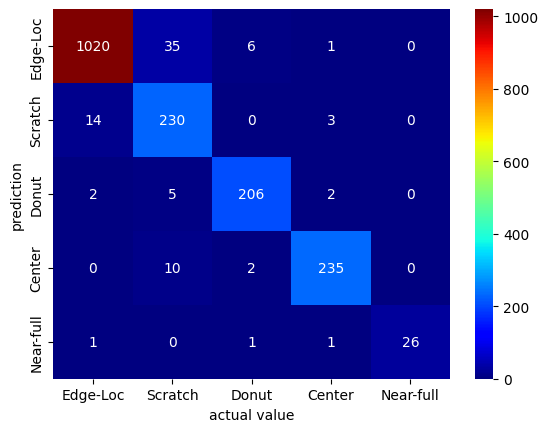

In [46]:
tick_labels = ["Edge-Loc", "Scratch", "Donut", "Center", "Near-full"]

all_dataset = WaferDataset(df_train)
all_dataloader = DataLoader(all_dataset, batch_size=batch_size)


pred_test = predict(model, all_dataloader)
y_test = getLabels(model, all_dataloader)
cm = confusion_matrix(y_test, pred_test, labels=[0, 1, 2, 3, 4])

sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=tick_labels,
            yticklabels=tick_labels,
            cmap='jet')

plt.xlabel('actual value')
plt.ylabel('prediction')

plt.show()
